In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from pylab import savefig

import os
import random

import logging

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchsummary import summary

from torch.utils.data import random_split, DataLoader

from sklearn.metrics import fbeta_score, cohen_kappa_score, balanced_accuracy_score, confusion_matrix
import torchmetrics

from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTImageProcessor

from datasets import get_test_dataset
from utils import compute_test_metrics
from datasets.iarc_dataset import collate_fn

comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
test_set = get_test_dataset('iarc_general', 'multiclass')

In [3]:
c_fn = collate_fn()

In [4]:
test_dataloader = DataLoader(test_set, batch_size=16, num_workers=4, collate_fn=c_fn, shuffle=True)

In [5]:
print("Dataset infos\nTest: %d" % test_set.__len__())

Dataset infos
Test: 259


In [6]:
ids2labels = {'Normal': 0, 'CIN1': 1, 'CIN2': 2, 'CIN3': 3}
model_pre_trained = 'google/vit-base-patch16-224-in21k'

In [7]:
log_path = '/workspace/work/vit/models/vit_iarc_general_multiclass/'
logging.basicConfig(filename=log_path+"test.log", level=logging.INFO,
                    format="%(asctime)s %(message)s")
logging.info('')
logging.info('ViT for IARC dataset (Colpo and VIA merged and without any data augmentation technique.')
logging.info('Test step...')
logging.info('')

In [8]:
best_model = ViTForImageClassification.from_pretrained(
    model_pre_trained,
    num_labels=len(ids2labels),
    ignore_mismatched_sizes = True,
    id2label={i: c for i, c in enumerate(ids2labels)},
    label2id={c: i for i, c in enumerate(ids2labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
best_model_path = '/workspace/work/vit/models/vit_iarc_general_multiclass/best_model.pth'
checkpoint = torch.load(os.path.join(best_model_path))
best_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [10]:
#checkpoint

In [11]:
print("Best model epoch: {:d}".format(checkpoint['epoch']))
logging.info("Best model epoch: {:d}".format(checkpoint['epoch']))
logging.info('')

Best model epoch: 100


usar model.eval()

In [12]:
def test_step(test_dataloader, best_model):
    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_dataloader)):
            best_model.eval()
            inputs, labels = batch['pixel_values'], batch['labels']
            outputs = best_model(pixel_values=inputs, labels=labels)
        
            logits = outputs.logits
        
            y_pred = np.concatenate([y_pred, torch.argmax(logits, dim=-1).tolist()])
            y_true = np.concatenate([y_true, labels])
    
    return y_true, y_pred

In [13]:
y_true, y_pred = test_step(test_dataloader, best_model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:09<00:00,  1.74it/s]


In [14]:
test_fb = compute_test_metrics(y_true, y_pred, 'fb_score')
test_kappa = compute_test_metrics(y_true, y_pred, 'cohen_kappa')
test_acc_b = compute_test_metrics(y_true, y_pred, 'balanced_accuracy')

test_metrics_info = "Fb score: {:.3f}, C Kappa: {:.3f}, Bal Acc: {:.3f}".format((test_fb*100),
                                                                                (test_kappa*100),
                                                                                (test_acc_b*100))

In [15]:
print(test_metrics_info)
logging.info('Metrics values')
logging.info(test_metrics_info)

Fb score: 51.678, C Kappa: 4.686, Bal Acc: 25.607


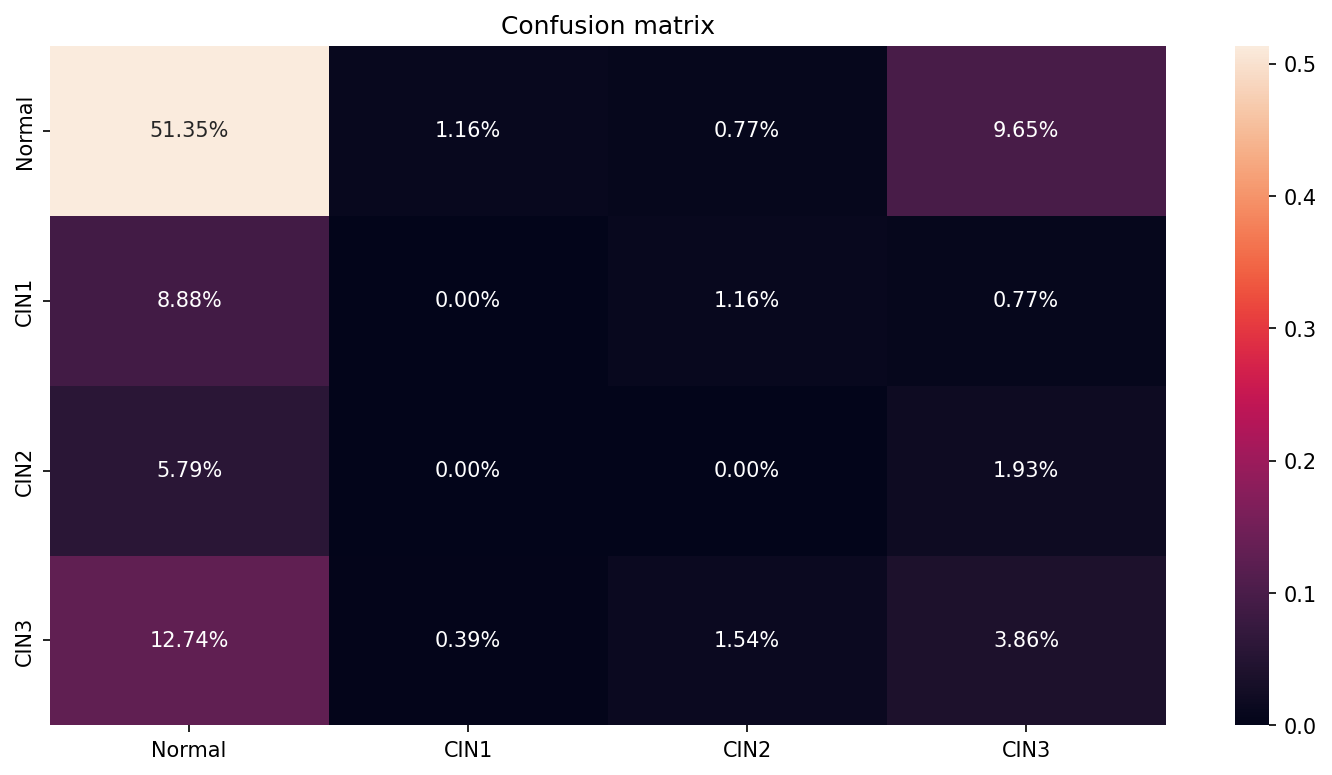

In [16]:
cm = confusion_matrix(y_true, y_pred)

best_model_cm = pd.DataFrame(
    cm,
    index = {c: i for i, c in enumerate(ids2labels)},
    columns = {c: i for i, c in enumerate(ids2labels)}
)

plt.figure(figsize = (12, 6), dpi=150)
plt.title('Confusion matrix')
svm = sns.heatmap(best_model_cm/np.sum(cm), fmt='.2%', annot=True)

figure = svm.get_figure()
figure.savefig('/workspace/work/vit/models/vit_iarc_general_multiclass/cm_iarc_general_multiclass.png',
               dpi=400)